# ML Approach

#### We will work with different Datasets. We will work with the Dataset from the BUC station:

In [28]:
#import modules
import numpy as np
import pandas as pd
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.feature_selection import SelectFromModel

#ML packages
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

#save fitted model:
import pickle
#color palette
colors = sns.color_palette("Set2")
from IPython.display import HTML

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV


In [29]:
BUC_csv= pd.read_csv("./data/cleaned_data/230513/230513_BUC_3B.csv",index_col="x")
BUC_csv["datetime"]=pd.to_datetime(BUC_csv['datetime'], format="%Y-%m-%d %H:%M:%S")
print(len(BUC_csv))
print(BUC_csv.columns)

15958
Index(['datetime', 'bulk_temp', 'skin_temp', 'air_temp', 'precipitation',
       'windspeed', 'solar_W', 'rel_humidity', 'air_pressure'],
      dtype='object')


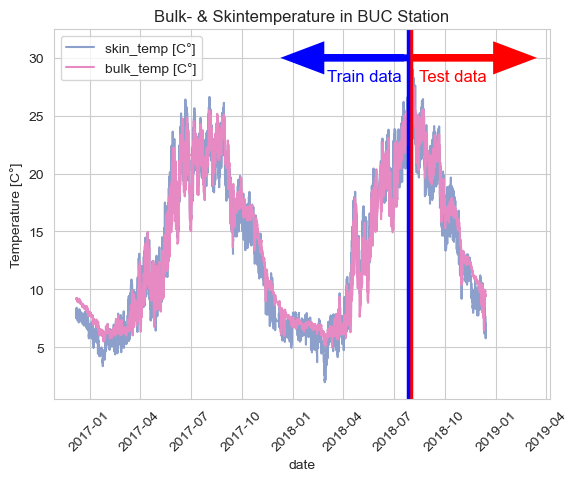

In [30]:
plt.plot(BUC_csv["datetime"],BUC_csv["skin_temp"],label="skin_temp [C°]",color=colors[2])
plt.plot(BUC_csv["datetime"],BUC_csv["bulk_temp"],label="bulk_temp [C°]",color=colors[3])

#Vertical Line
plt.axvline(x=pd.Timestamp("2018-08-01"),color="red",linewidth=2.5)
plt.axvline(x=pd.Timestamp("2018-07-26"),color="blue",linewidth=2.5)

#Arrows
plt.arrow(pd.Timestamp("2018-08-05"),30,150,0,head_width=2, head_length=55, fc='red', ec='red',linewidth=5)
plt.text(pd.Timestamp("2018-08-16"), 28, "Test data", fontsize=12,color="red")

plt.arrow(pd.Timestamp("2018-07-20"),30,-150,0,head_width=2, head_length=55, fc='blue', ec='blue',linewidth=5)
plt.text(pd.Timestamp("2018-03-04"), 28, "Train data", fontsize=12,color="blue")
plt.xticks(rotation=45)
#Other things
plt.title("Bulk- & Skintemperature in BUC Station")
plt.xlabel("date")
plt.ylabel("Temperature [C°]")
plt.legend(loc="upper left")

In [31]:
# Split Dataset to Train and Test data:
row = BUC_csv.loc[BUC_csv['datetime'] == pd.Timestamp('2018-08-05')]
train_set=BUC_csv[:row.index[0]]
test_set=BUC_csv[row.index[0]:]

print(f"Train set: {len(train_set)} observations, {round((len(train_set)/len(BUC_csv))*100)}% of the whole Dataset")
print(f"Train set: {len(test_set)} observations, {round((len(test_set)/len(BUC_csv))*100)}% of the whole Dataset")

Train set: 12917 observations, 81% of the whole Dataset
Train set: 3042 observations, 19% of the whole Dataset


## Gradient Boosting Regression

In [32]:
#CODE:
def apply_table_styles(df):
    return df.style.set_table_styles(
        [
            {
                'selector': 'th',
                'props': [('background-color', 'lightgray')]
            },
            {
                'selector': 'tbody tr:nth-child(even)',
                'props': [('background-color', "lightblue")]
            }
        ]
    )


comparison_dict = {
    'Algorithm': ['Random Forest', 'Gradient Boosting Regression'],
    'Training approach': ['Independent and parallel', 'Sequential and residuals'],
    'Bias-variance tradeoff': ['Higher bias, lower variance', 'Lower bias, higher variance'],
    'Speed': ['Faster for large datasets', 'Slower for large datasets'],
    'Hyperparameters': ['Number of trees, maximum depth', 'Learning rate, number of trees'],
    'Interpretability': ['Lower', 'Higher'],
    'Handling missing values': ['Able to handle missing values', 'Not able to handle missing values'],
    'Robustness to outliers': ['More robust', 'Less robust'],
    'Model performance': ['Stable performance', 'Tendency to overfit']
}

# Convert the dictionary to a pandas DataFrame
comparison_df = pd.DataFrame.from_dict(comparison_dict).T.rename_axis('Algorithm', axis=1).drop(index="Algorithm")
comparison_df.columns = ['Random Forest', 'Gradient Boosting Regression']

# Create a simple dataset
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = np.sin(X).ravel()


# Create Gradient Boosting Regression model
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)

# Train model on data
gbr.fit(X, y)

GradientBoostingRegressor(max_depth=4, random_state=42)

#### What is this algorithm (simple explanation):
The GBR works by combining many decision trees. Each tree tries to fix the mistakes made by the previous trees. The trees are added together, creating an ensemble that makes a prediction.

The hyperparameters of GBR include the number of trees in the ensemble (n_estimators), the learning rate (learning_rate) that controls the contribution of each tree to the ensemble, and the maximum depth of each tree (max_depth), among others.

-> These hyperparameters need to be tuned carefully to obtain the best performance from the model. So we will use the CrossValidationCV module, which is quite good.

An decision tree is visualized below:

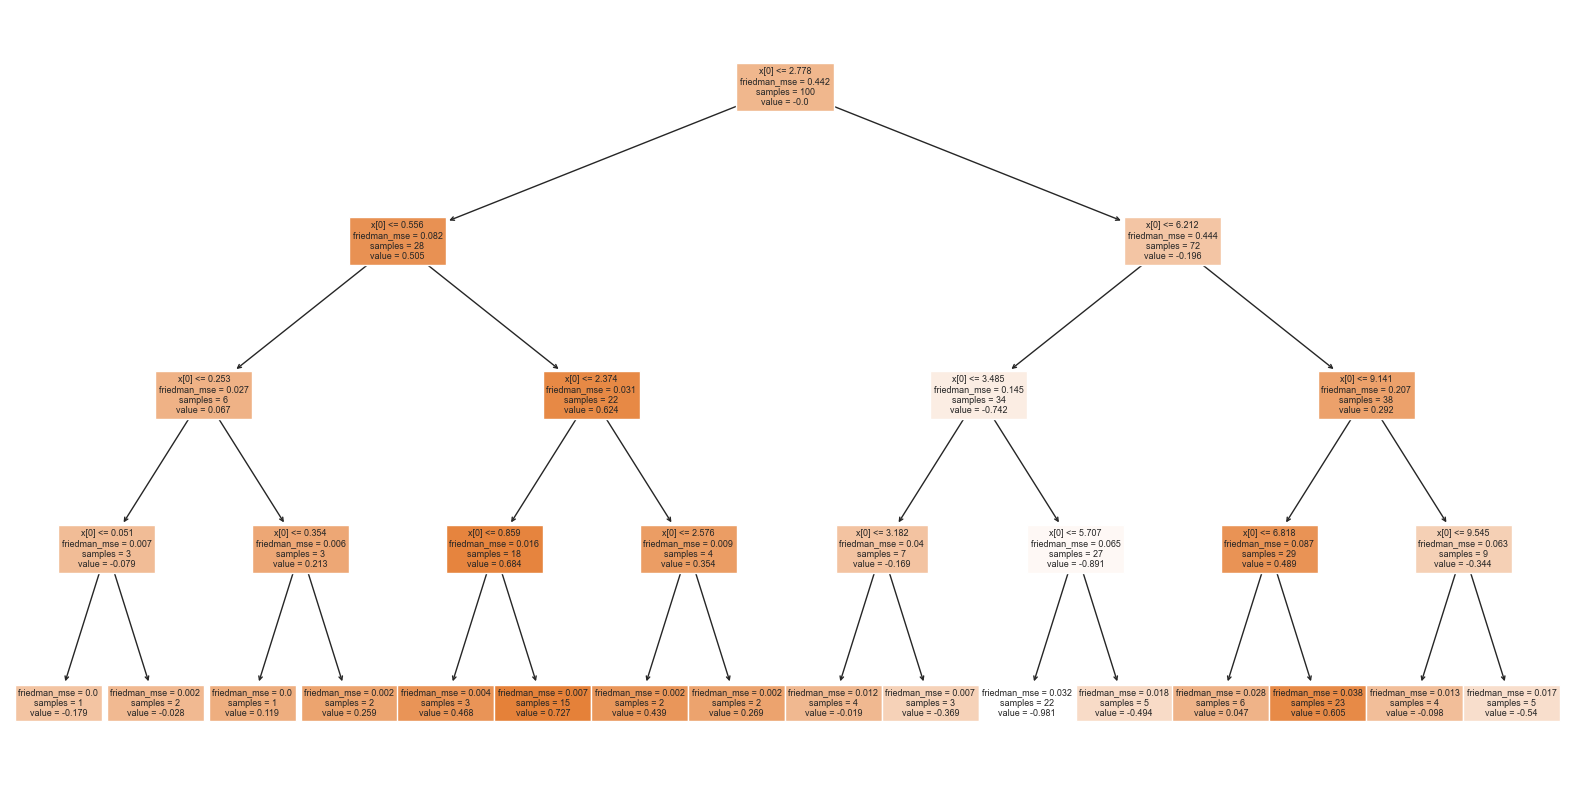

In [33]:
plt.figure(figsize=(20, 10))
plot_tree(gbr.estimators_[0, 0], filled=True)
plt.show()

#### But what is the difference between GBR and RF?

In [34]:
display(apply_table_styles(comparison_df))

,Random Forest,Gradient Boosting Regression
Training approach,Independent and parallel,Sequential and residuals
Bias-variance tradeoff,"Higher bias, lower variance","Lower bias, higher variance"
Speed,Faster for large datasets,Slower for large datasets
Hyperparameters,"Number of trees, maximum depth","Learning rate, number of trees"
Interpretability,Lower,Higher
Handling missing values,Able to handle missing values,Not able to handle missing values
Robustness to outliers,More robust,Less robust
Model performance,Stable performance,Tendency to overfit


## Coding the GBR Model with CrossValidation and Hyperparameter tuning: (Attempt 1: Bulk Temperature and Skin Temperature)

In [35]:
#MODES:
fit=False
filename = './data/models_data/GBR_model_BulkSkinTemp_HalvingGridSearchCV.sav'

BUC_csv= pd.read_csv("./data/cleaned_data/230513/230513_BUC_3B.csv",index_col="x")
BUC_csv["datetime"]=pd.to_datetime(BUC_csv['datetime'], format="%Y-%m-%d %H:%M:%S")
BUC_csv.columns

Index(['datetime', 'bulk_temp', 'skin_temp', 'air_temp', 'precipitation',
       'windspeed', 'solar_W', 'rel_humidity', 'air_pressure'],
      dtype='object')

In [36]:
#add day/night hot encoding:
BUC_csv['day_night'] = BUC_csv['datetime'].dt.hour.apply(lambda x: 1 if x>=6 and x<18 else 2)
train_set=BUC_csv[:row.index[0]]
test_set=BUC_csv[row.index[0]:]

#Grid search is quite useful here:
#define the parameters to choose from
param_grid = {
    "max_depth": [3,5,7,9],
    "learning_rate": [0.01,0.1],
}
#define the scorer, in this case we can use the mean squared error:
mse_scorer = make_scorer(mean_squared_error,greater_is_better=False)

#initialize the model:
gbr = GradientBoostingRegressor()

#make the GridSearch:

grid_search1 = HalvingGridSearchCV(
    estimator=gbr, #implement the GradienBoostingRegressor
    param_grid=param_grid, #the defined parameters (see above)
    scoring=mse_scorer, #the lower the score (in this case the mse), the better the model
    cv=5, #5-fold Cross Validation -> quite normal here!
    n_jobs=-1, #use 1 core of the CPU
    verbose=10,#print progress messages
    factor=2,
    resource="n_estimators",
    max_resources=1500
)
#fit it to the train-set: if False, the fitted model will be loaded from disk:
if fit == True:
    grid_search1.fit(train_set.drop(columns=["bulk_temp","datetime"]),train_set["bulk_temp"])
    pickle.dump(grid_search1, open(filename, 'wb'))

else:
    grid_search1 = pickle.load(open(filename, 'rb'))


#get the best hyperparameters and the mse:
best_params = grid_search1.best_params_
best_score = grid_search1.best_score_
print("----------------------------")
print("Best Parameters:",best_params)
print("Best Score (MSE):",best_score)


----------------------------
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1496}
Best Score (MSE): -0.5525279372263275


In [37]:
best_estimator= grid_search1.best_estimator_
feature_importances=pd.DataFrame({"feature name": train_set.drop(columns=["bulk_temp","datetime"]).columns,"importance": best_estimator.feature_importances_})
print(feature_importances.sort_values("importance",ascending=False))

    feature name  importance
0      skin_temp    0.983296
1       air_temp    0.012234
4        solar_W    0.001722
5   rel_humidity    0.001128
3      windspeed    0.001077
6   air_pressure    0.000451
7      day_night    0.000092
2  precipitation    0.000000


In [38]:
# Evaluate the best model on the testing set
test_set=test_set.copy()
test_set["bulk_temp_predicted"]= grid_search1.predict(test_set.drop(columns=["bulk_temp","datetime"]))

mse=mean_squared_error(test_set["bulk_temp_predicted"],test_set["bulk_temp"])
r2=r2_score(test_set["bulk_temp"],test_set["bulk_temp_predicted"])
n = len(test_set["bulk_temp"])  # number of observations
p = 5  # number of predictors (features)
r2_adjusted = 1 - (1 - r2) * (n - 1) / (n - p - 1)

----------------------------------
Mean Squared Error: 0.655
R-squared score: 0.972
Adjusted R-squared score: 0.972
----------------------------------


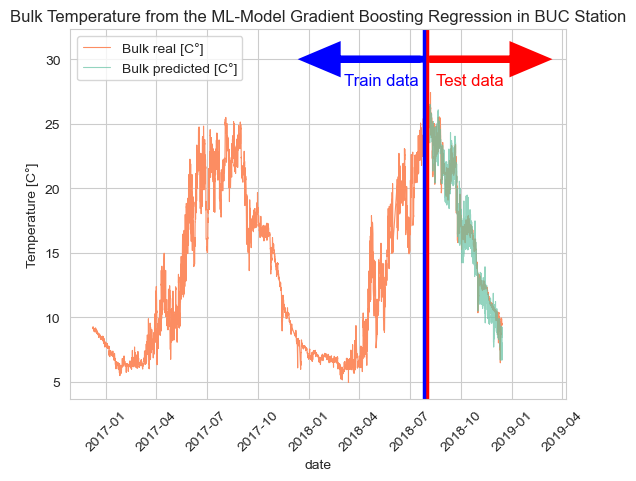

In [39]:
plt.plot(BUC_csv["datetime"],BUC_csv["bulk_temp"],label="Bulk real [C°]", color=colors[1],alpha=1,linewidth =0.8)
plt.plot(test_set["datetime"],test_set["bulk_temp_predicted"],label="Bulk predicted [C°]", color=colors[0],alpha=0.7,linewidth =0.8)
plt.xticks(rotation=45)

#Vertical Line
plt.axvline(x=pd.Timestamp("2018-08-01"),color="red",linewidth=2.5)
plt.axvline(x=pd.Timestamp("2018-07-26"),color="blue",linewidth=2.5)

#Arrows
plt.arrow(pd.Timestamp("2018-08-05"),30,150,0,head_width=2, head_length=55, fc='red', ec='red',linewidth=5)
plt.text(pd.Timestamp("2018-08-16"), 28, "Test data", fontsize=12,color="red")

plt.arrow(pd.Timestamp("2018-07-20"),30,-150,0,head_width=2, head_length=55, fc='blue', ec='blue',linewidth=5)
plt.text(pd.Timestamp("2018-03-04"), 28, "Train data", fontsize=12,color="blue")

#Other things
plt.title("Bulk Temperature from the ML-Model Gradient Boosting Regression in BUC Station")
plt.xlabel("date")
plt.ylabel("Temperature [C°]")
plt.legend(loc="upper left")
print(f"\033[94m----------------------------------\033[0m")
print(f"\033[94mMean Squared Error: {round(mse,3)}\nR-squared score: {round(r2,3)}\nAdjusted R-squared score: {round(r2_adjusted,3)}\033[0m")
print(f"\033[94m----------------------------------\033[0m")


### Model evaluation:

Lets see how the difference between the predicted and the real bulk temperature is:

In [40]:
display("Real Bulk Temperature minus Skin Temperature")
frame=(test_set["bulk_temp"]-test_set["skin_temp"]).describe().to_frame()
display(apply_table_styles(frame))

display("Predicted Bulk Temperature minus Skin Temperature")
frame=(test_set["bulk_temp_predicted"]-test_set["skin_temp"]).describe().to_frame()
display(apply_table_styles(frame))

display("Predicted Bulk Temperature minus real Bulk Temperature")
frame=(test_set["bulk_temp_predicted"]-test_set["bulk_temp"]).describe().to_frame()
display(apply_table_styles(frame))

display("We can see that the interpretation is quite challanging. Another option is to train the model on Bulk Temperature - Skin Temperature to predict the Skin effect itself")

'Real Bulk Temperature minus Skin Temperature'

,0
count,3042.000000
mean,0.932293
std,1.011221
min,-3.691588
25%,0.256528
50%,0.964166
75%,1.645340
max,3.698130


'Predicted Bulk Temperature minus Skin Temperature'

,0
count,3042.000000
mean,0.547647
std,0.883163
min,-2.524849
25%,-0.056179
50%,0.556884
75%,1.177518
max,3.090350


'Predicted Bulk Temperature minus real Bulk Temperature'

,0
count,3042.000000
mean,-0.384646
std,0.712450
min,-2.885432
25%,-0.802097
50%,-0.402732
75%,0.003750
max,3.064545


'We can see that the interpretation is quite challanging. Another option is to train the model on Bulk Temperature - Skin Temperature to predict the Skin effect itself'

## Coding the GBR Model with CrossValidation and Hyperparameter tuning: (Attempt 2: Skin Effect)

In [41]:
#MODES:
fit=False
filename = './data/models_data/GBR_skin_model_HalvingGridSearchCV.sav'

In [42]:
BUC_csv= pd.read_csv("./data/cleaned_data/230513/230513_BUC_3B.csv",index_col="x")
BUC_csv["datetime"]=pd.to_datetime(BUC_csv['datetime'], format="%Y-%m-%d %H:%M:%S")

In [43]:
#add skin effect:
BUC_csv["skin_effect"]=BUC_csv["skin_temp"].subtract(BUC_csv["bulk_temp"])
BUC_csv=BUC_csv.drop(columns=["bulk_temp"])

In [44]:
display(BUC_csv.head())

,datetime,skin_temp,air_temp,precipitation,windspeed,solar_W,rel_humidity,air_pressure,skin_effect
x,,,,,,,,,
1.481105e+09,2016-12-07 11:00:00,7.872472,1.286,0.0,1.723,87.3,89.40,0.0,-1.253696
1.481108e+09,2016-12-07 12:00:00,7.515649,2.091,0.0,1.255,153.4,85.50,0.0,-1.646734
1.481112e+09,2016-12-07 13:00:00,7.884641,3.290,0.0,0.606,191.9,79.91,0.0,-1.326454
1.481116e+09,2016-12-07 14:00:00,8.158961,3.362,0.0,1.621,136.9,82.40,0.0,-1.070613
1.481119e+09,2016-12-07 15:00:00,8.281036,3.531,0.0,1.720,156.1,82.50,0.0,-0.930450


In [45]:
#add day/night hot encoding:
BUC_csv['day_night'] = BUC_csv['datetime'].dt.hour.apply(lambda x: True if x>=6 and x<18 else False)

train_set=BUC_csv[:row.index[0]]
test_set=BUC_csv[row.index[0]:]


#Grid search is quite useful here:
#define the parameters to choose from
param_grid = {
    "max_depth": [3,5,7,9],
    "learning_rate": [0.01,0.1],
}
#define the scorer, in this case we can use the mean squared error:
mse_scorer = make_scorer(r2_score)

#initialize the model:
gbr = GradientBoostingRegressor()

#make the GridSearch:

grid_search2 = HalvingGridSearchCV(
    estimator=gbr, #implement the GradienBoostingRegressor
    param_grid=param_grid, #the defined parameters (see above)
    scoring=mse_scorer, #the lower the score (in this case the mse), the better the model
    cv=5, #5-fold Cross Validation -> quite normal here!
    n_jobs=-1, #use 1 core of the CPU
    verbose=10,#print progress messages
    factor=2,
    resource="n_estimators",
    max_resources=1500
)
#fit it to the train-set: if False, the fitted model will be loaded from disk:
if fit == True:
    grid_search2.fit(train_set.drop(columns=["skin_effect","datetime"]),train_set["skin_effect"])
    pickle.dump(grid_search2, open(filename, 'wb'))

else:
    grid_search2 = pickle.load(open(filename, 'rb'))


#get the best hyperparameters and the mse:
best_params = grid_search2.best_params_
best_score = grid_search2.best_score_
print("----------------------------")
print("Best Parameters:",best_params)
print("Best Score (r2):",best_score)

----------------------------
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1496}
Best Score (r2): 0.5045091005549052


In [46]:
test_set=test_set.copy()
display(test_set)
test_set["skin_effect_predicted"]= grid_search2.predict(test_set.drop(columns=["skin_effect","datetime"]))

mse=mean_squared_error(test_set["skin_effect_predicted"],test_set["skin_effect"])
r2=r2_score(test_set["skin_effect"],test_set["skin_effect_predicted"])
n = len(test_set["skin_effect"])  # number of observations
p = 5  # number of predictors (features)
r2_adjusted = 1 - (1 - r2) * (n - 1) / (n - p - 1)

,datetime,skin_temp,air_temp,precipitation,windspeed,solar_W,rel_humidity,air_pressure,skin_effect,day_night
x,,,,,,,,,,
1.533420e+09,2018-08-05 00:00:00,24.832645,25.030,0.0,1.134,0.0,63.96,974.0,-0.634496,False
1.533424e+09,2018-08-05 01:00:00,24.620767,23.890,0.0,0.984,0.0,68.66,974.0,-0.507276,False
1.533427e+09,2018-08-05 02:00:00,24.372886,23.060,0.0,1.067,0.0,72.14,973.0,-0.806873,False
1.533431e+09,2018-08-05 03:00:00,24.031870,21.630,0.0,1.308,0.0,78.64,973.0,-1.119904,False
1.533434e+09,2018-08-05 04:00:00,23.793295,21.490,0.0,1.266,0.0,79.46,973.0,-1.260766,False
...,...,...,...,...,...,...,...,...,...,...
1.544688e+09,2018-12-13 09:00:00,5.779573,-1.467,0.0,2.467,30.0,72.05,969.0,-3.698130,True
1.544692e+09,2018-12-13 10:00:00,5.906152,-0.691,0.0,2.761,194.1,68.96,969.0,-3.596117,True
1.544695e+09,2018-12-13 11:00:00,6.274966,0.201,0.0,3.478,297.3,65.67,969.0,-3.246991,True


----------------------------------
Mean Squared Error: 0.652
R-squared score: 0.362
Adjusted R-squared score: 0.361

Feature Importance:
    feature name  importance
0       air_temp    0.542485
1      skin_temp    0.267743
2        solar_W    0.075834
3   rel_humidity    0.060403
4      windspeed    0.036816
5   air_pressure    0.010865
6      day_night    0.005853
7  precipitation    0.000000
----------------------------------


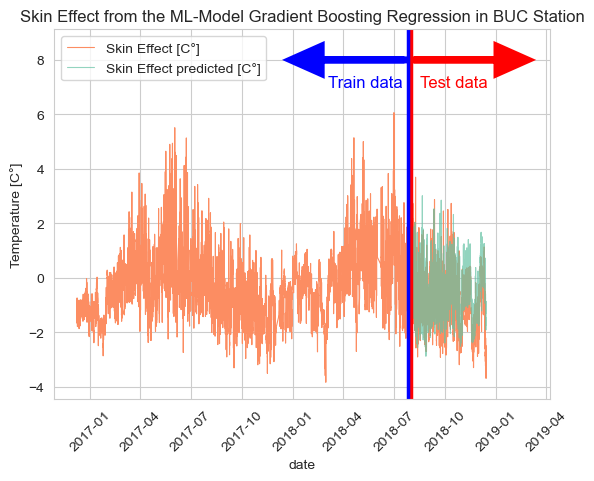

In [60]:
plt.plot(BUC_csv["datetime"],BUC_csv["skin_effect"],label="Skin Effect [C°]", color=colors[1],alpha=1,linewidth =0.8)
plt.plot(test_set["datetime"],test_set["skin_effect_predicted"],label="Skin Effect predicted [C°]", color=colors[0],alpha=0.7,linewidth =0.8)
plt.xticks(rotation=45)

#Vertical Line
plt.axvline(x=pd.Timestamp("2018-08-01"),color="red",linewidth=2.5)
plt.axvline(x=pd.Timestamp("2018-07-26"),color="blue",linewidth=2.5)

#Arrows
plt.arrow(pd.Timestamp("2018-08-05"),8,150,0,head_width=1, head_length=55, fc='red', ec='red',linewidth=5)
plt.text(pd.Timestamp("2018-08-16"), 7, "Test data", fontsize=12,color="red")

plt.arrow(pd.Timestamp("2018-07-20"),8,-150,0,head_width=1, head_length=55, fc='blue', ec='blue',linewidth=5)
plt.text(pd.Timestamp("2018-03-04"), 7, "Train data", fontsize=12,color="blue")

#Other things
plt.title("Skin Effect from the ML-Model Gradient Boosting Regression in BUC Station")
plt.xlabel("date")
plt.ylabel("Temperature [C°]")
plt.legend()
print(f"\033[94m----------------------------------\033[0m")
print(f"\033[94mMean Squared Error: {round(mse,3)}\nR-squared score: {round(r2,3)}\nAdjusted R-squared score: {round(r2_adjusted,3)}\033[0m")


#best estimator:
best_estimator= grid_search2.best_estimator_
feature_importances=pd.DataFrame({"feature name": train_set.drop(columns=["skin_effect","datetime"]).columns,"importance": best_estimator.feature_importances_})
print("")
print(f"\033[94mFeature Importance:\033[0m")
print(f"\033[94m{feature_importances.sort_values('importance',ascending=False).reset_index(drop=True)}\033[0m")
print(f"\033[94m----------------------------------\033[0m")



## Coding a RF Model with CrossValidation and Hyperparameter tuning: (Attempt 3: Skin Effect)


What is a Random Forest Model?

-> A Random Forest Model is a ML-Model that combines multiple Decision Trees to Classify or Predict from multivariate Data. This model tends to be more robust as the GBR (more details see below).

In [48]:
display(apply_table_styles(comparison_df))

,Random Forest,Gradient Boosting Regression
Training approach,Independent and parallel,Sequential and residuals
Bias-variance tradeoff,"Higher bias, lower variance","Lower bias, higher variance"
Speed,Faster for large datasets,Slower for large datasets
Hyperparameters,"Number of trees, maximum depth","Learning rate, number of trees"
Interpretability,Lower,Higher
Handling missing values,Able to handle missing values,Not able to handle missing values
Robustness to outliers,More robust,Less robust
Model performance,Stable performance,Tendency to overfit


In [49]:
BUC_csv= pd.read_csv("./data/cleaned_data/230513/230513_BUC_3B.csv",index_col="x")
BUC_csv["datetime"]=pd.to_datetime(BUC_csv['datetime'], format="%Y-%m-%d %H:%M:%S")

#add day/night hot encoding:
BUC_csv['day_night'] = BUC_csv['datetime'].dt.hour.apply(lambda x: True if x>=6 and x<18 else False)
#add skin effect:
BUC_csv["skin_effect"]=BUC_csv["skin_temp"].subtract(BUC_csv["bulk_temp"])
BUC_csv=BUC_csv.drop(columns=["bulk_temp"])

#Split Dataset into Train and Testset
train_set=BUC_csv[:row.index[0]]
test_set=BUC_csv[row.index[0]:]

In [50]:
#Grid search is quite useful here:
#define the parameters to choose from
param_grid = {
    "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    "max_depth": [9],
    #"min_samples_split": [2]
}
#define the scorer, in this case we can use the mean squared error:
scorer = make_scorer(r2_score)
#scorer = make_scorer(mean_absolute_error)

#initialize the model:
rfr = RandomForestRegressor()

#make the GridSearch:

grid_search3 = HalvingGridSearchCV(
    estimator=rfr, #implement the GradienBoostingRegressor
    param_grid=param_grid, #the defined parameters (see above)
    scoring=mse_scorer, #the lower the score (in this case the mse), the better the model
    cv=5, #5-fold Cross Validation -> quite normal here!
    n_jobs=-1, #use 1 core of the CPU
    verbose=10,#print progress messages
    factor=2,
    resource="n_estimators",
    max_resources=1500
)
#fit it to the train-set: if False, the fitted model will be loaded from disk:
if fit == True:
    grid_search3.fit(train_set.drop(columns=["skin_effect","datetime"]),train_set["skin_effect"])
    pickle.dump(grid_search3, open(filename, 'wb'))

else:
    grid_search3 = pickle.load(open(filename, 'rb'))


#get the best hyperparameters and the mse:
best_params = grid_search3.best_params_
best_score = grid_search3.best_score_
print("----------------------------")
print("Best Parameters:",best_params)
print("Best Score (mae):",best_score)

----------------------------
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1496}
Best Score (mae): 0.5045091005549052


In [51]:
#MODES:
fit=False
filename = './data/models_data/RF_skin_model_HalvingGridSearchCV.sav'

In [52]:
test_set=test_set.copy()
test_set["skin_effect_predicted"]= grid_search3.predict(test_set.drop(columns=["skin_effect","datetime"]))

mse=mean_squared_error(test_set["skin_effect_predicted"],test_set["skin_effect"])
r2=r2_score(test_set["skin_effect"],test_set["skin_effect_predicted"])
n = len(test_set["skin_effect"])  # number of observations
p = 5  # number of predictors (features)
r2_adjusted = 1 - (1 - r2) * (n - 1) / (n - p - 1)

----------------------------------
Mean Squared Error: 0.652
R-squared score: 0.362
Adjusted R-squared score: 0.361

Feature Importance:
    feature name  importance
0       air_temp    0.542485
1      skin_temp    0.267743
2        solar_W    0.075834
3   rel_humidity    0.060403
4      windspeed    0.036816
5   air_pressure    0.010865
6      day_night    0.005853
7  precipitation    0.000000
----------------------------------


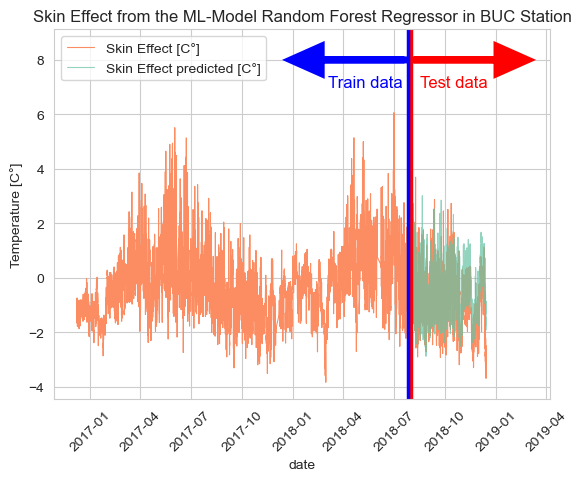

In [59]:
plt.plot(BUC_csv["datetime"],BUC_csv["skin_effect"],label="Skin Effect [C°]", color=colors[1],alpha=1,linewidth =0.8)
plt.plot(test_set["datetime"],test_set["skin_effect_predicted"],label="Skin Effect predicted [C°]", color=colors[0],alpha=0.7,linewidth =0.8)
plt.xticks(rotation=45)

#Vertical Line
plt.axvline(x=pd.Timestamp("2018-08-01"),color="red",linewidth=2.5)
plt.axvline(x=pd.Timestamp("2018-07-26"),color="blue",linewidth=2.5)

#Arrows
plt.arrow(pd.Timestamp("2018-08-05"),8,150,0,head_width=1, head_length=55, fc='red', ec='red',linewidth=5)
plt.text(pd.Timestamp("2018-08-16"), 7, "Test data", fontsize=12,color="red")

plt.arrow(pd.Timestamp("2018-07-20"),8,-150,0,head_width=1, head_length=55, fc='blue', ec='blue',linewidth=5)
plt.text(pd.Timestamp("2018-03-04"), 7, "Train data", fontsize=12,color="blue")

#Other things
plt.title("Skin Effect from the ML-Model Random Forest Regressor in BUC Station")
plt.xlabel("date")
plt.ylabel("Temperature [C°]")
plt.legend()
print(f"\033[94m----------------------------------\033[0m")
print(f"\033[94mMean Squared Error: {round(mse,3)}\nR-squared score: {round(r2,3)}\nAdjusted R-squared score: {round(r2_adjusted,3)}\033[0m")


#best estimator:
best_estimator= grid_search3.best_estimator_
feature_importances=pd.DataFrame({"feature name": train_set.drop(columns=["skin_effect","datetime"]).columns,"importance": best_estimator.feature_importances_})
print("")
print(f"\033[94mFeature Importance:\033[0m")
print(f"\033[94m{feature_importances.sort_values('importance',ascending=False).reset_index(drop=True)}\033[0m")
print(f"\033[94m----------------------------------\033[0m")